In [66]:
import pandas as pd
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

checkpoints_dir = './checkpoints'
checkpoint_csv_files = glob(os.path.join(checkpoints_dir, '*-errorAnalysis.csv'))

print(checkpoint_csv_files)

['./checkpoints/openai-gpt-5-mini:fullPrompt:openrouter-errorAnalysis.csv']


In [67]:
df = pd.read_csv(checkpoint_csv_files[-1]) 



In [68]:
print(df.columns)
print(df.shape)

Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'raw_flop_counts', 'predicted_sp_flop_count',
       'predicted_dp_flop_count', 'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'percent_diff_sp',
       'percent_diff_dp', 'manualErrorClassification'],
      dtype='object')
(627, 34)


In [69]:
erroneous_cases = df[~df['manualErrorClassification'].isna()].copy()
print(erroneous_cases['manualErrorClassification'].shape)

(49,)


In [70]:
target_percent = 50
check_df = df[(df['percent_diff_sp'] > target_percent) | (df['percent_diff_dp'] > target_percent) | (df['percent_diff_sp'] < -target_percent) | (df['percent_diff_dp'] < -target_percent)]

assert erroneous_cases.shape[0] == check_df.shape[0]
assert erroneous_cases['langgraph_thread_id'].equals(check_df['langgraph_thread_id'])

In [71]:
# gather all the manualErrorClassification values and their counts
error_classes = set()

def scan_error_classes(errorStr):
    assert errorStr != None and errorStr != ''
    # split the errorStr by semicolon
    errors = errorStr.split(';')

    error_classes.update([e.strip() for e in errors if e.strip() != ''])

    return errorStr

erroneous_cases['manualErrorClassification'].apply(scan_error_classes)
print(f'Identified {len(error_classes)} unique error classes:')
for ec in error_classes:
    ec_str = ec
    # had to manually fix this one typo in the input file
    if 'uses half2 (FP16) precision' in ec_str:
        ec_str = 'uses half2 (FP16) precision reported as SP FLOPs'
    if '__global__' in ec_str:
        ec_str = 'incorrect global function input arg(s)'
        print('Fixed typo in error class')
    print(f' - {ec_str}')
    erroneous_cases[ec_str] = erroneous_cases['manualErrorClassification'].apply(lambda x: True if ec in x else False)


error_classes = ['uses half2 (FP16) precision reported as SP FLOPs' if 'uses half2 (FP16) precision' in ec else ec for ec in error_classes]
error_classes = ['incorrect global function input arg(s)' if '__global__' in ec else ec for ec in error_classes]

error_classes = sorted(list(error_classes))
print(erroneous_cases.columns)






Identified 16 unique error classes:
 - typedef float/double flipped
 - has FP division
 - uses half2 (FP16) precision reported as SP FLOPs
 - missing input arg needed from input file
 - typedef compiler arg -- not provided
 - treated sign flip as 0 FLOP
 - flop count explanation and reported value DIFFER
Fixed typo in error class
 - incorrect global function input arg(s)
 - incorrect global function input arg(s)
 - code comments made LLM assume X ops were taking place
 - uses half2 (FP16) precision reported as SP FLOPs
 - mistook exe args as a function input arg
 - missing header file with necessary code/values
 - has special math function
 - has common sub-expressions
 - has DD-warp divergence
Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
  

incorrect global function input arg(s)                   26
incorrect global function input arg(s)                   26
mistook exe args as a function input arg                 15
missing header file with necessary code/values           11
code comments made LLM assume X ops were taking place     5
has DD-warp divergence                                    5
missing input arg needed from input file                  5
has special math function                                 4
treated sign flip as 0 FLOP                               4
has FP division                                           3
uses half2 (FP16) precision reported as SP FLOPs          3
uses half2 (FP16) precision reported as SP FLOPs          3
typedef compiler arg -- not provided                      2
typedef float/double flipped                              2
flop count explanation and reported value DIFFER          1
has common sub-expressions                                1
dtype: int64


<Axes: ylabel='None'>

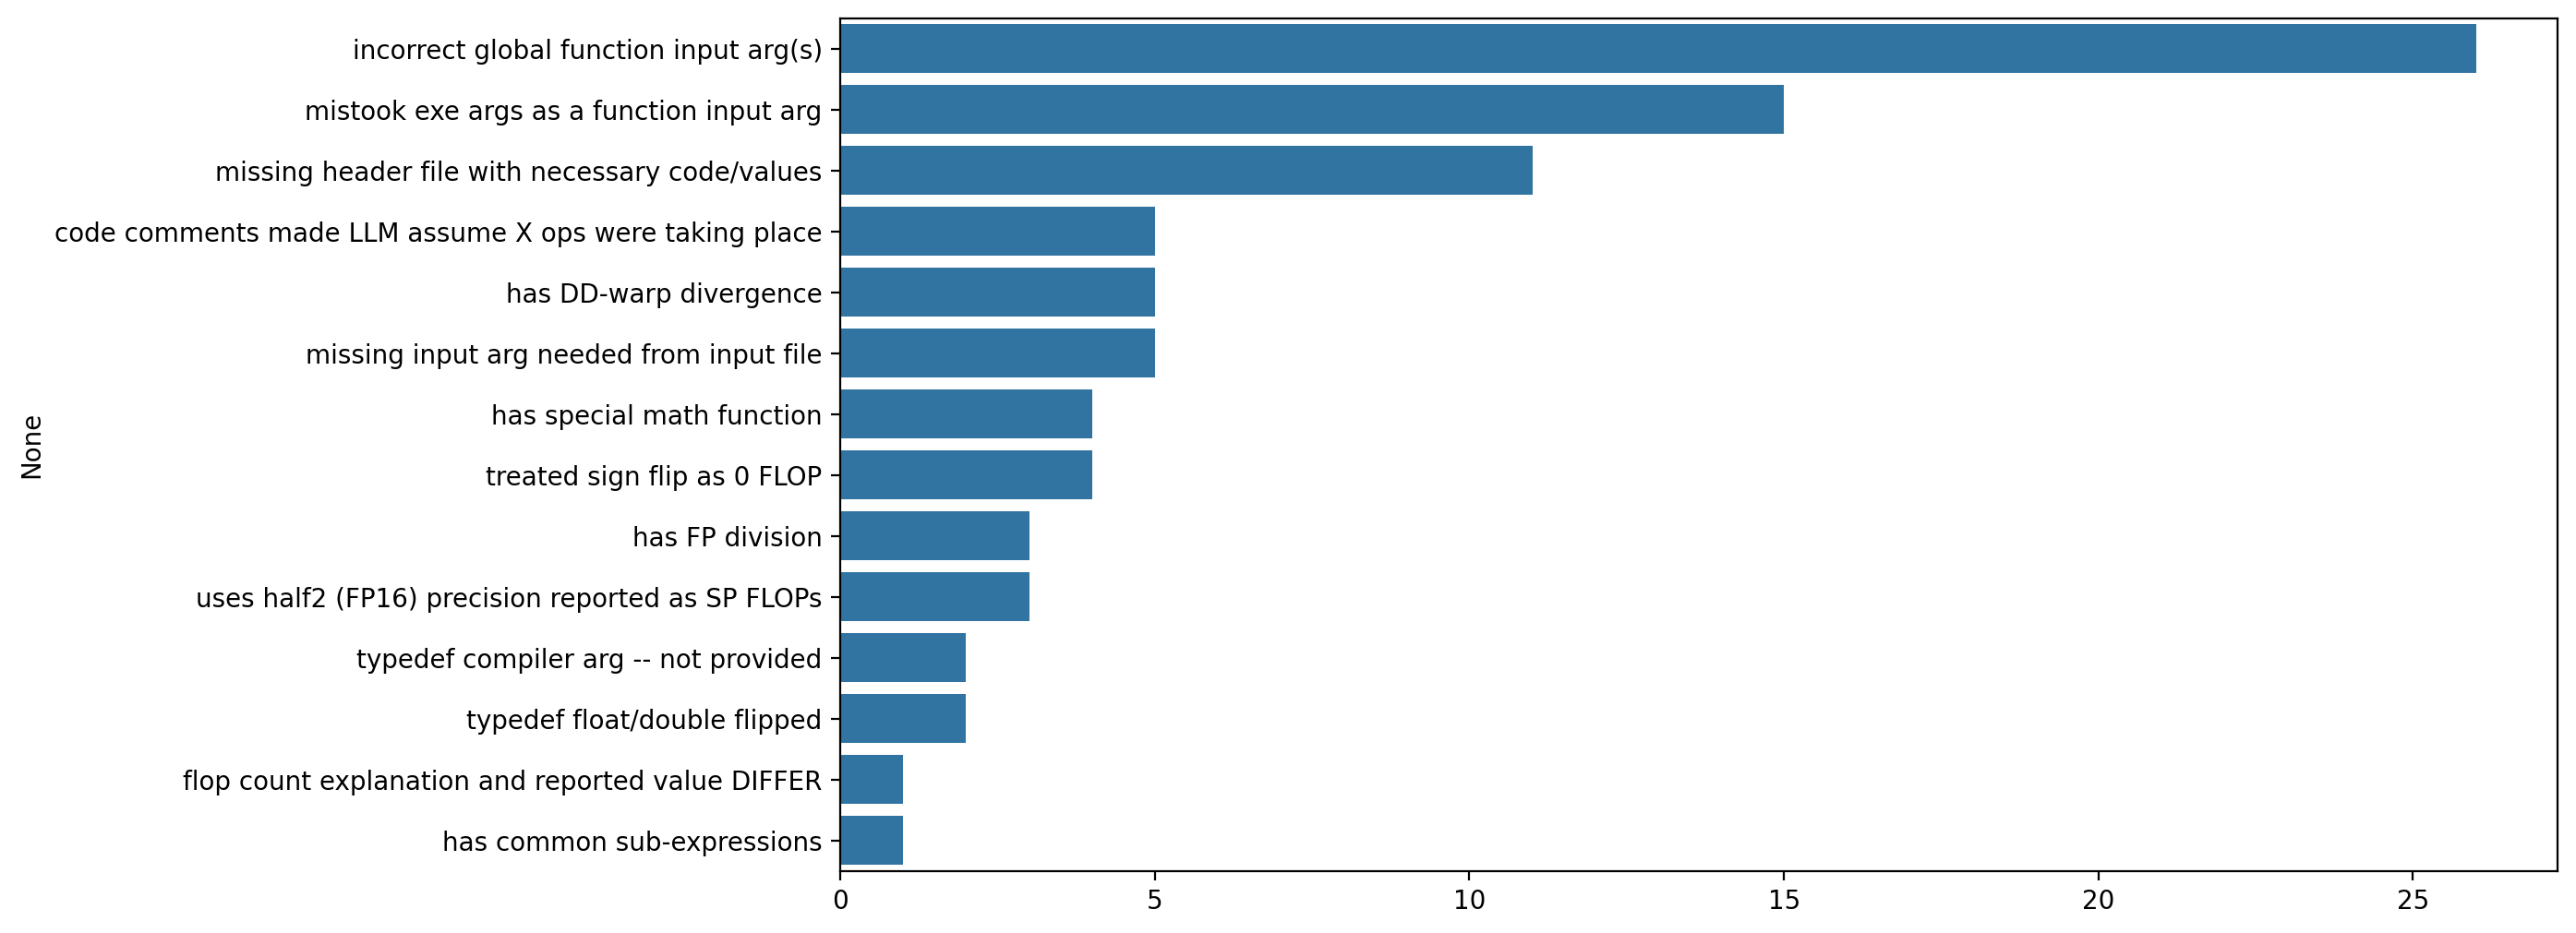

In [72]:
# let's visualize the distribution of error classes

fig, ax = plt.subplots(1,1 , figsize=(12, 6), dpi=200)

# get column True counts
counts = erroneous_cases[error_classes].sum().sort_values(ascending=False)

print(counts)

sns.barplot(y=counts.index, x=counts.values, ax=ax)


In [73]:
hard_code_features = ['has special math function', 
                      'has FP division', 
                      'has DD-warp divergence',
                      'has common sub-expressions']

hard_code_names = erroneous_cases[erroneous_cases[hard_code_features].any(axis=1)]['combined_name'].tolist()
hard_code_names = list(set(hard_code_names))

In [74]:
print(hard_code_names)

['(testSNAP-cuda, compute_yi)', '(rodrigues-cuda, rotate2)', '(attentionMultiHead-cuda, mha)']


incorrect global function input arg(s)                   21
incorrect global function input arg(s)                   21
mistook exe args as a function input arg                 15
missing header file with necessary code/values            6
code comments made LLM assume X ops were taking place     5
missing input arg needed from input file                  5
treated sign flip as 0 FLOP                               4
uses half2 (FP16) precision reported as SP FLOPs          3
uses half2 (FP16) precision reported as SP FLOPs          3
typedef compiler arg -- not provided                      2
typedef float/double flipped                              2
flop count explanation and reported value DIFFER          1
dtype: int64


Text(0.5, 0, 'Sample Count')

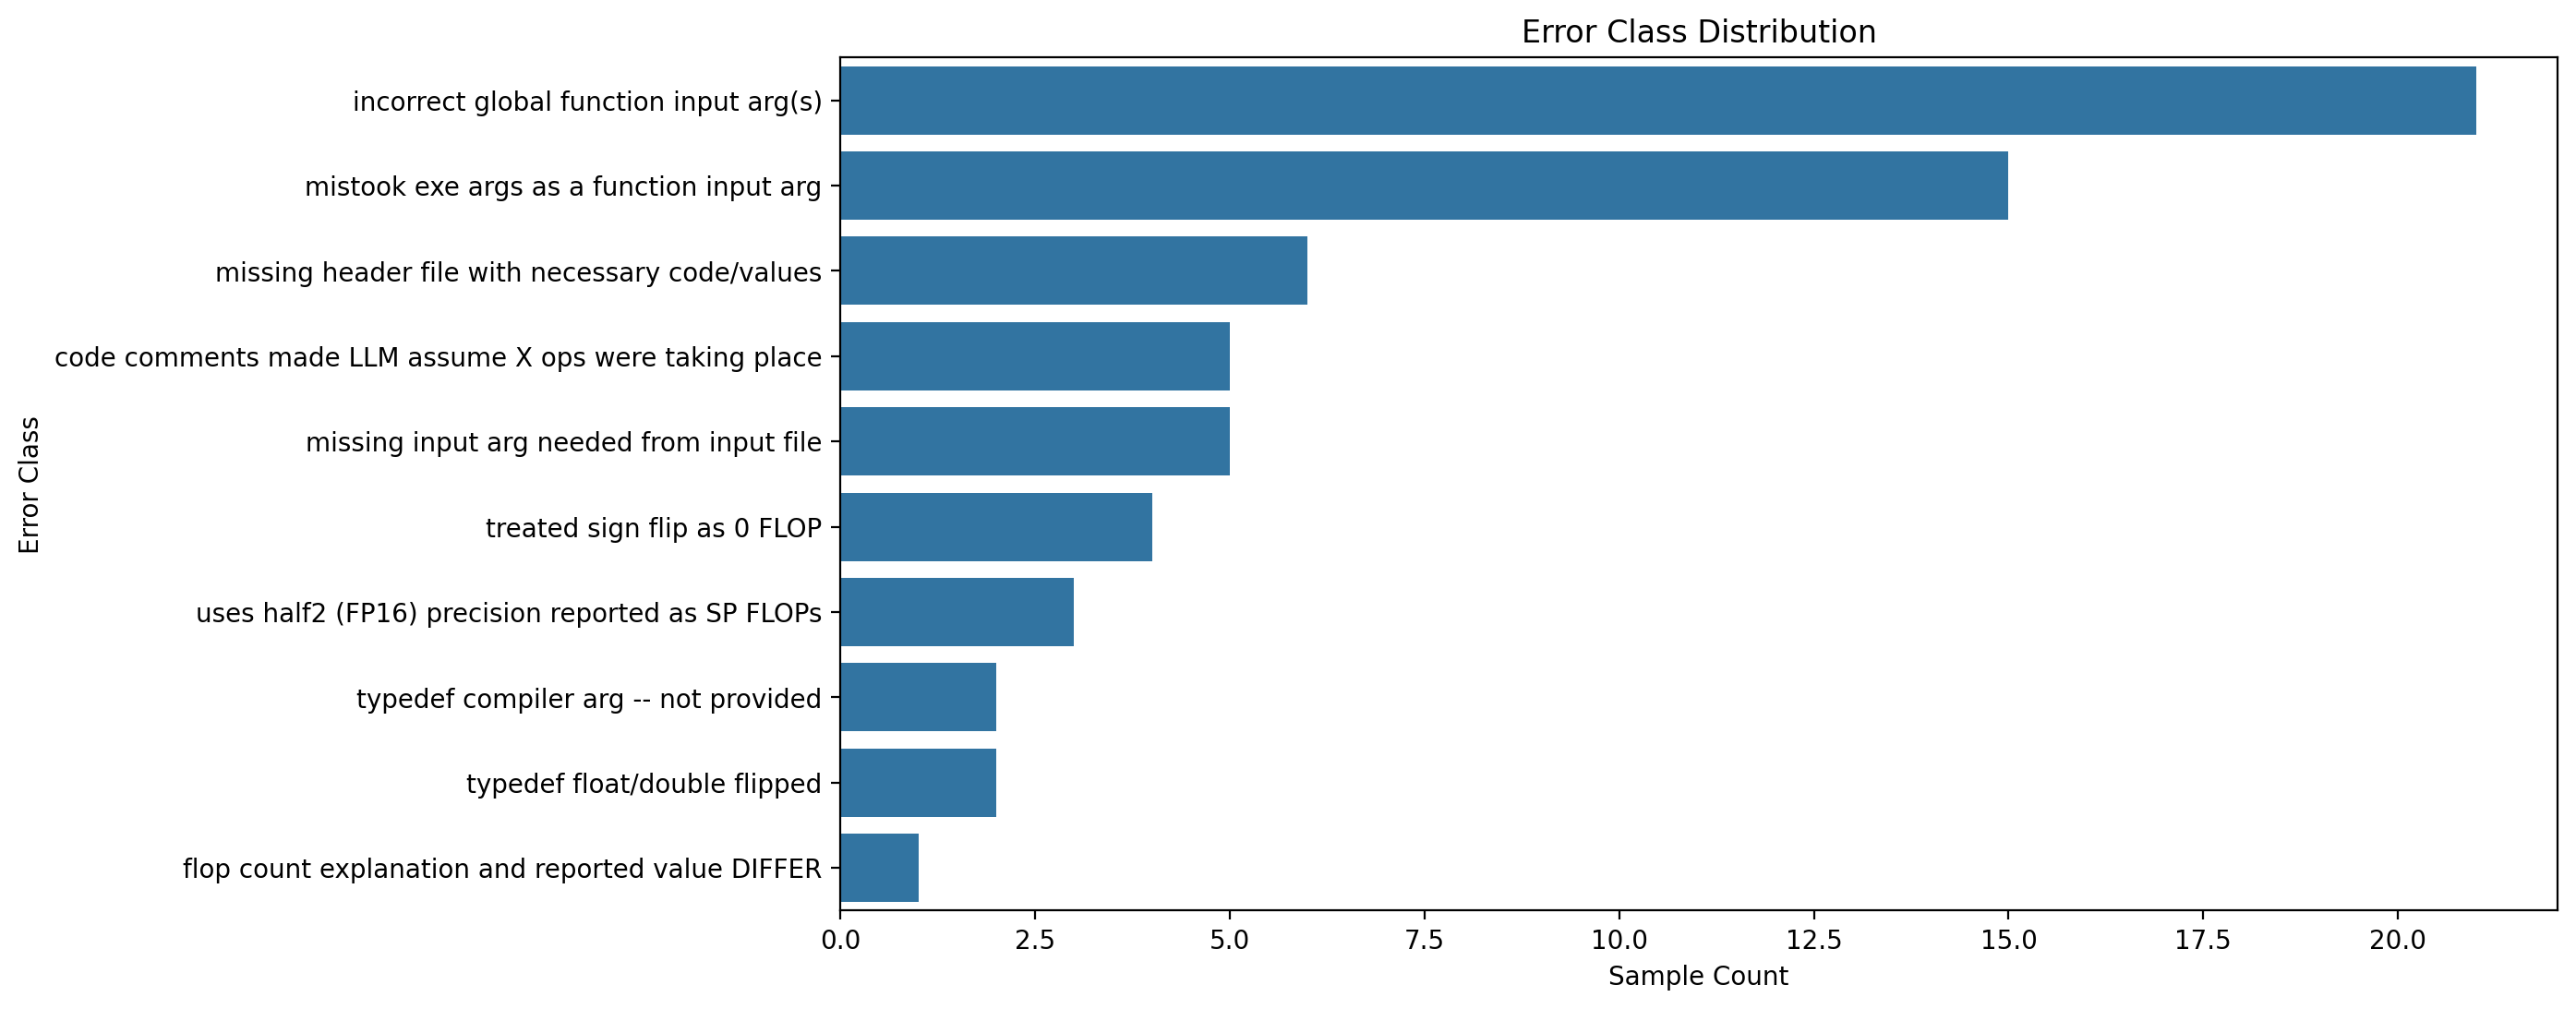

In [75]:

fig, ax = plt.subplots(1,1 , figsize=(12, 6), dpi=200)

erroneous_cases = erroneous_cases[~erroneous_cases['combined_name'].isin(hard_code_names)].copy()

erroneous_case_ids = list(erroneous_cases['langgraph_thread_id'].unique())

# get column True counts
counts = erroneous_cases[error_classes].sum().sort_values(ascending=False)

# drop counts that are zero
counts = counts[counts > 0]

print(counts)

sns.barplot(y=counts.index, x=counts.values, ax=ax)

ax.set_title('Error Class Distribution')
ax.set_ylabel('Error Class')
ax.set_xlabel('Sample Count')

In [76]:
# drop the hard_code_names from the df
df = df[~df['combined_name'].isin(hard_code_names)].copy()

print(df['prompt_type'].value_counts())
print(df.shape)

prompt_type
full    609
Name: count, dtype: int64
(609, 34)


In [77]:
def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', show_erroneous=True):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type)]
    success_df = sub_df[(sub_df['error'] == 'Success')]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')
    # overlay erroneous cases in red with X marker for visibility
    err_df = sub_df[sub_df['langgraph_thread_id'].isin(erroneous_case_ids)]
    err_df_sp = err_df[err_df['percent_diff_sp'] != 0]
    err_df_dp = err_df[err_df['percent_diff_dp'] != 0]
    if not err_df.empty and show_erroneous:
        sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=err_df_sp, label='Mispredicted', alpha=0.9, ax=ax, color='red', marker='X', s=30)
        sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=err_df_dp, label='', alpha=0.9, ax=ax, color='red', marker='X', s=30)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(f'CDF of Percent Differences \n({model_name} -- {prompt_type} prompt)')

    plt.tight_layout()
    plt.show()

    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

Success DF Size: (609, 34)


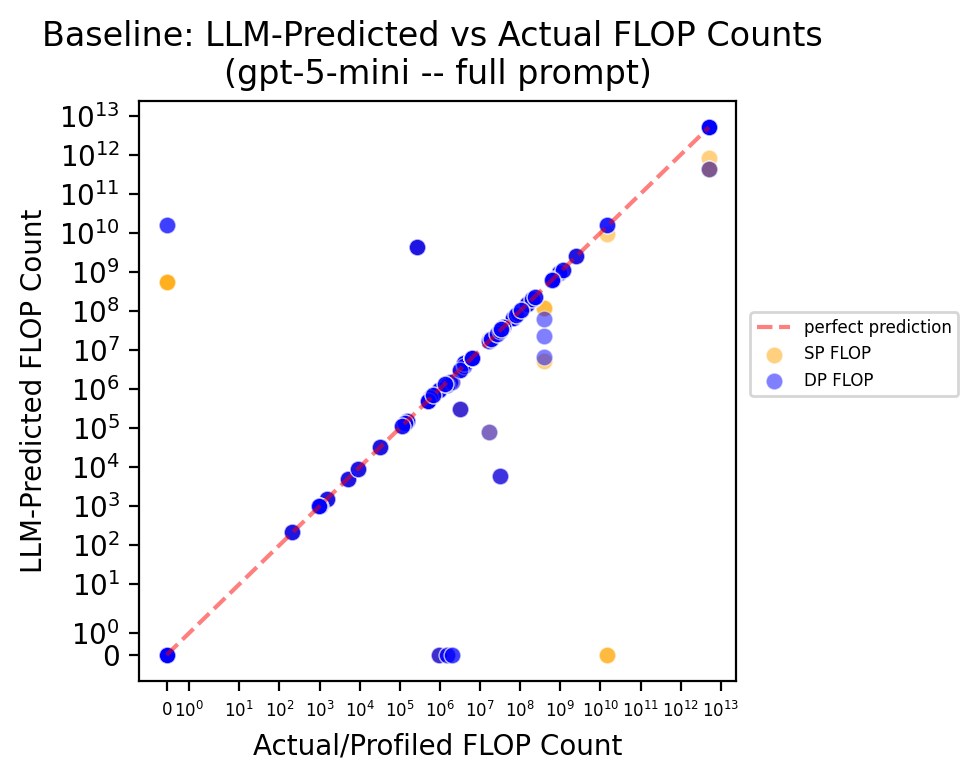

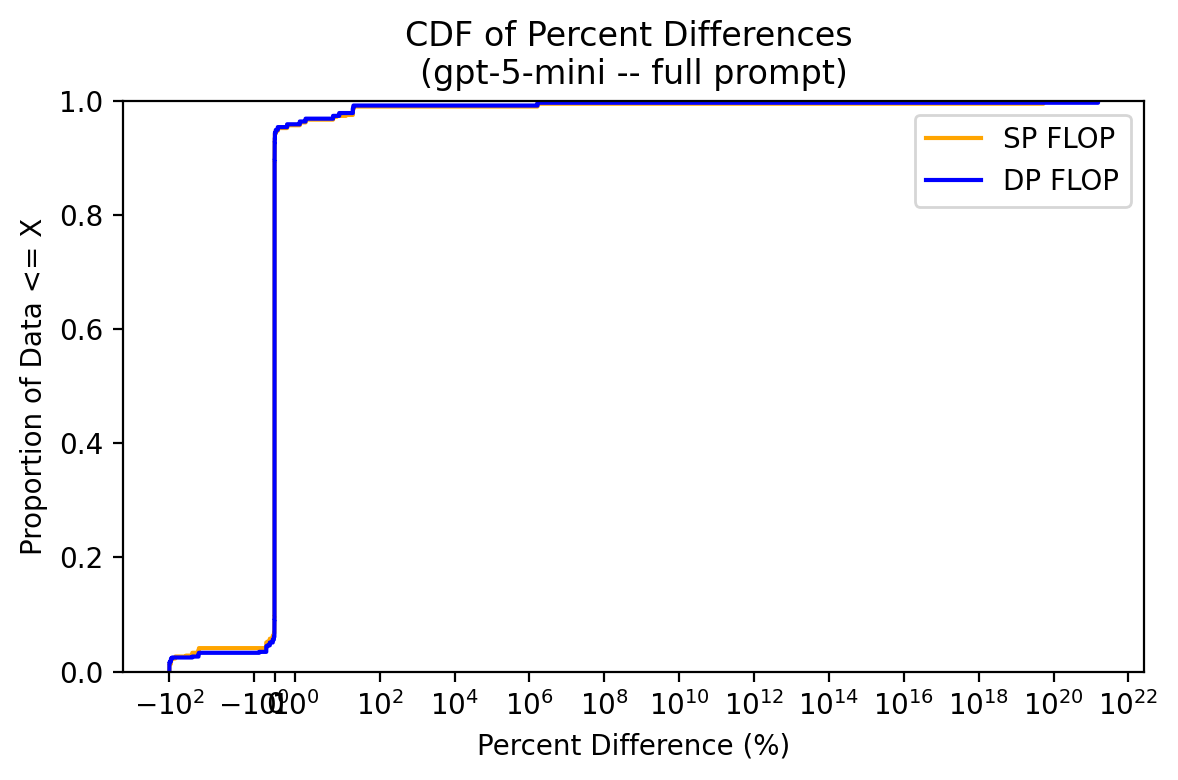

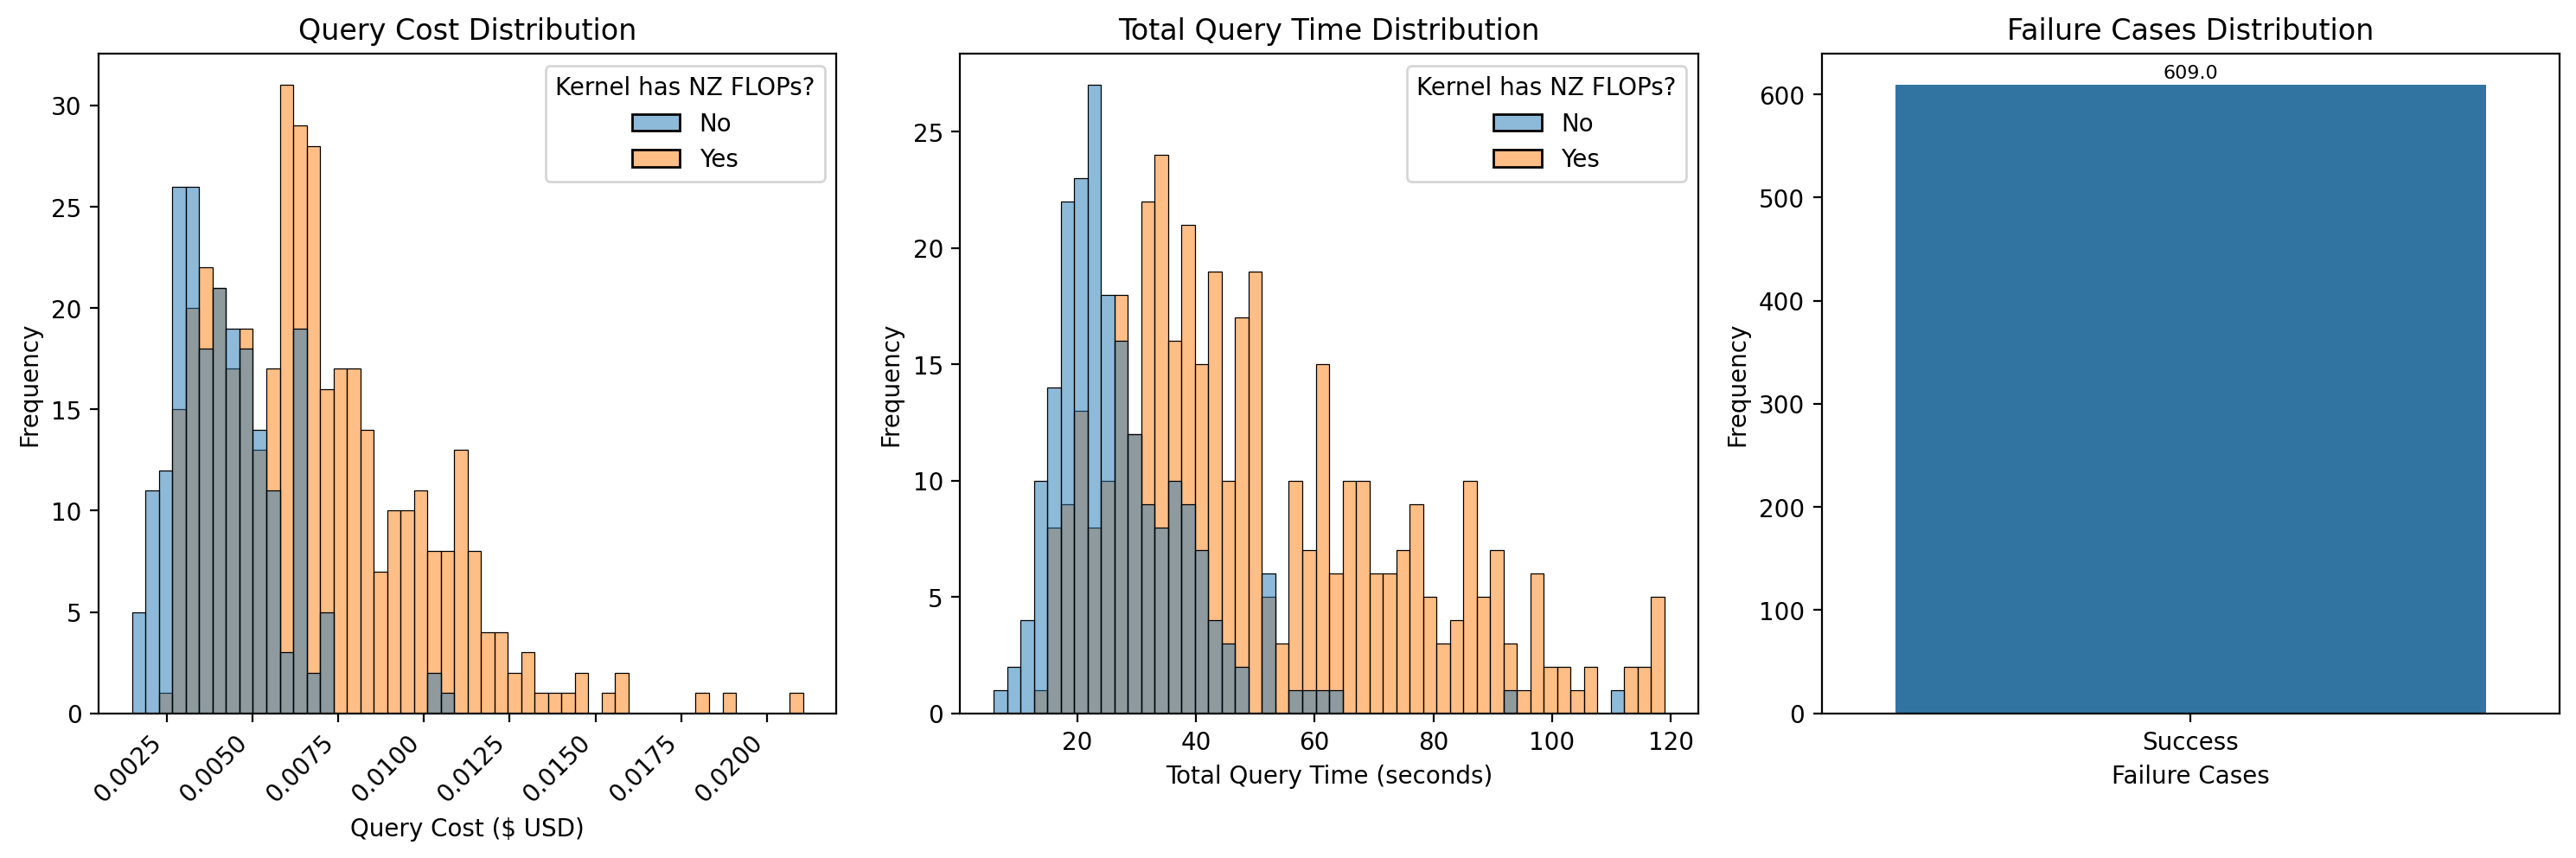

Success DF Size: (609, 34)


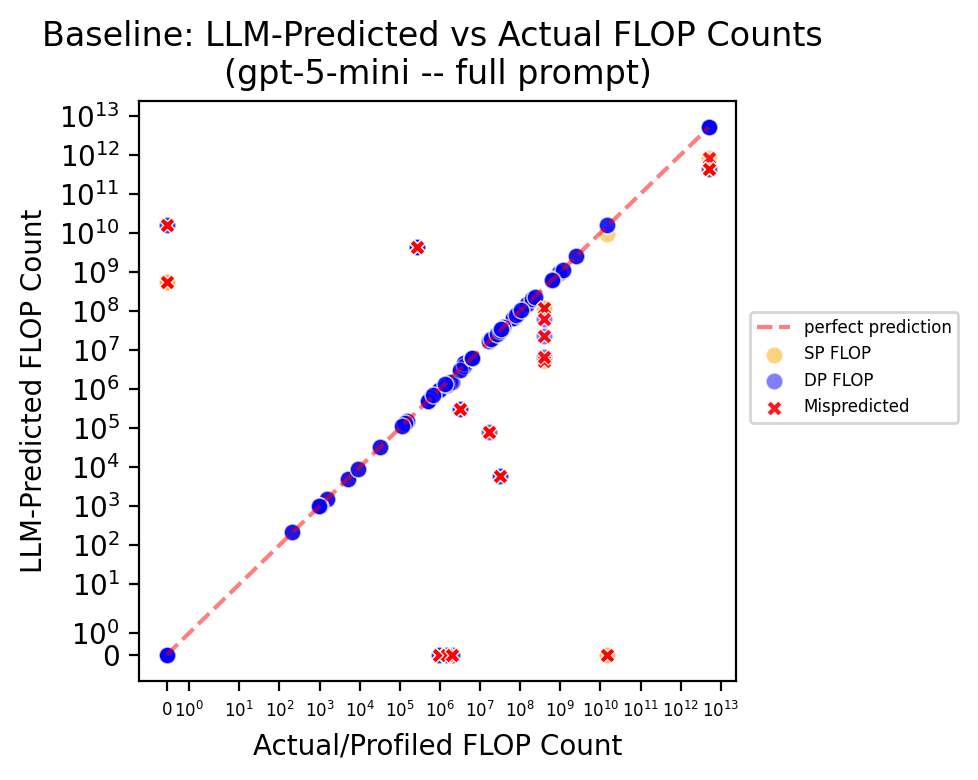

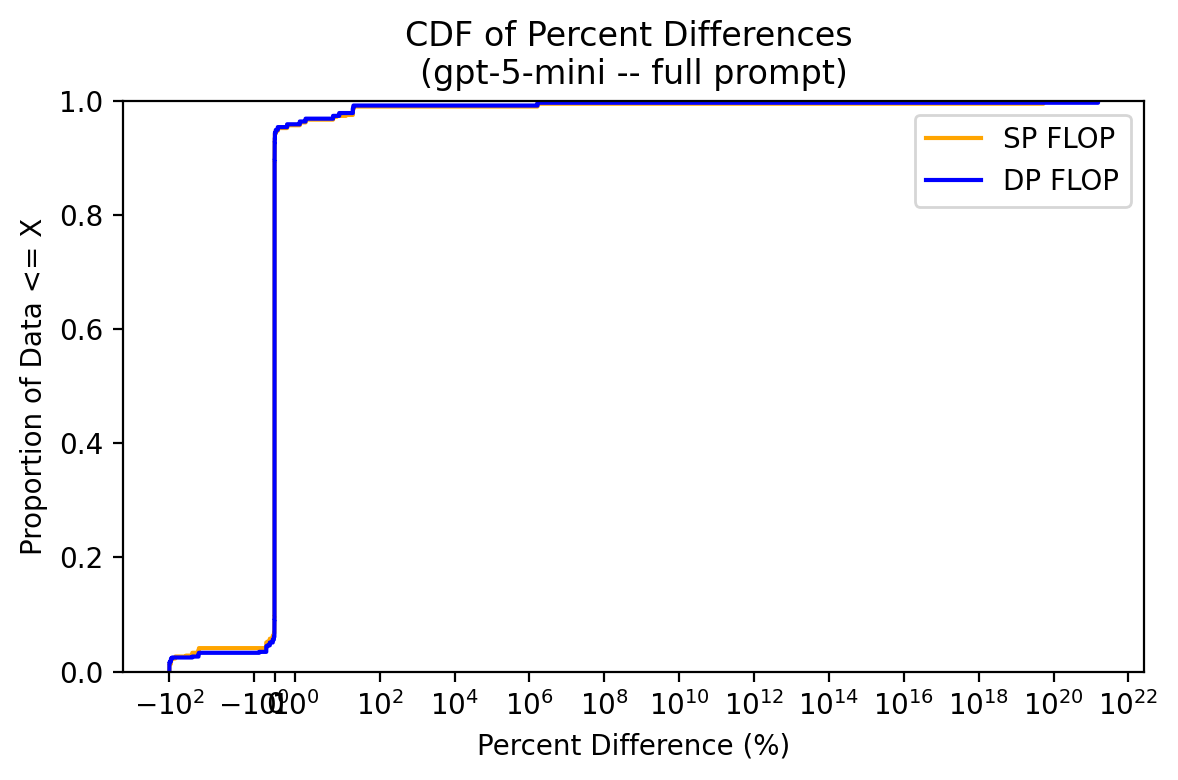

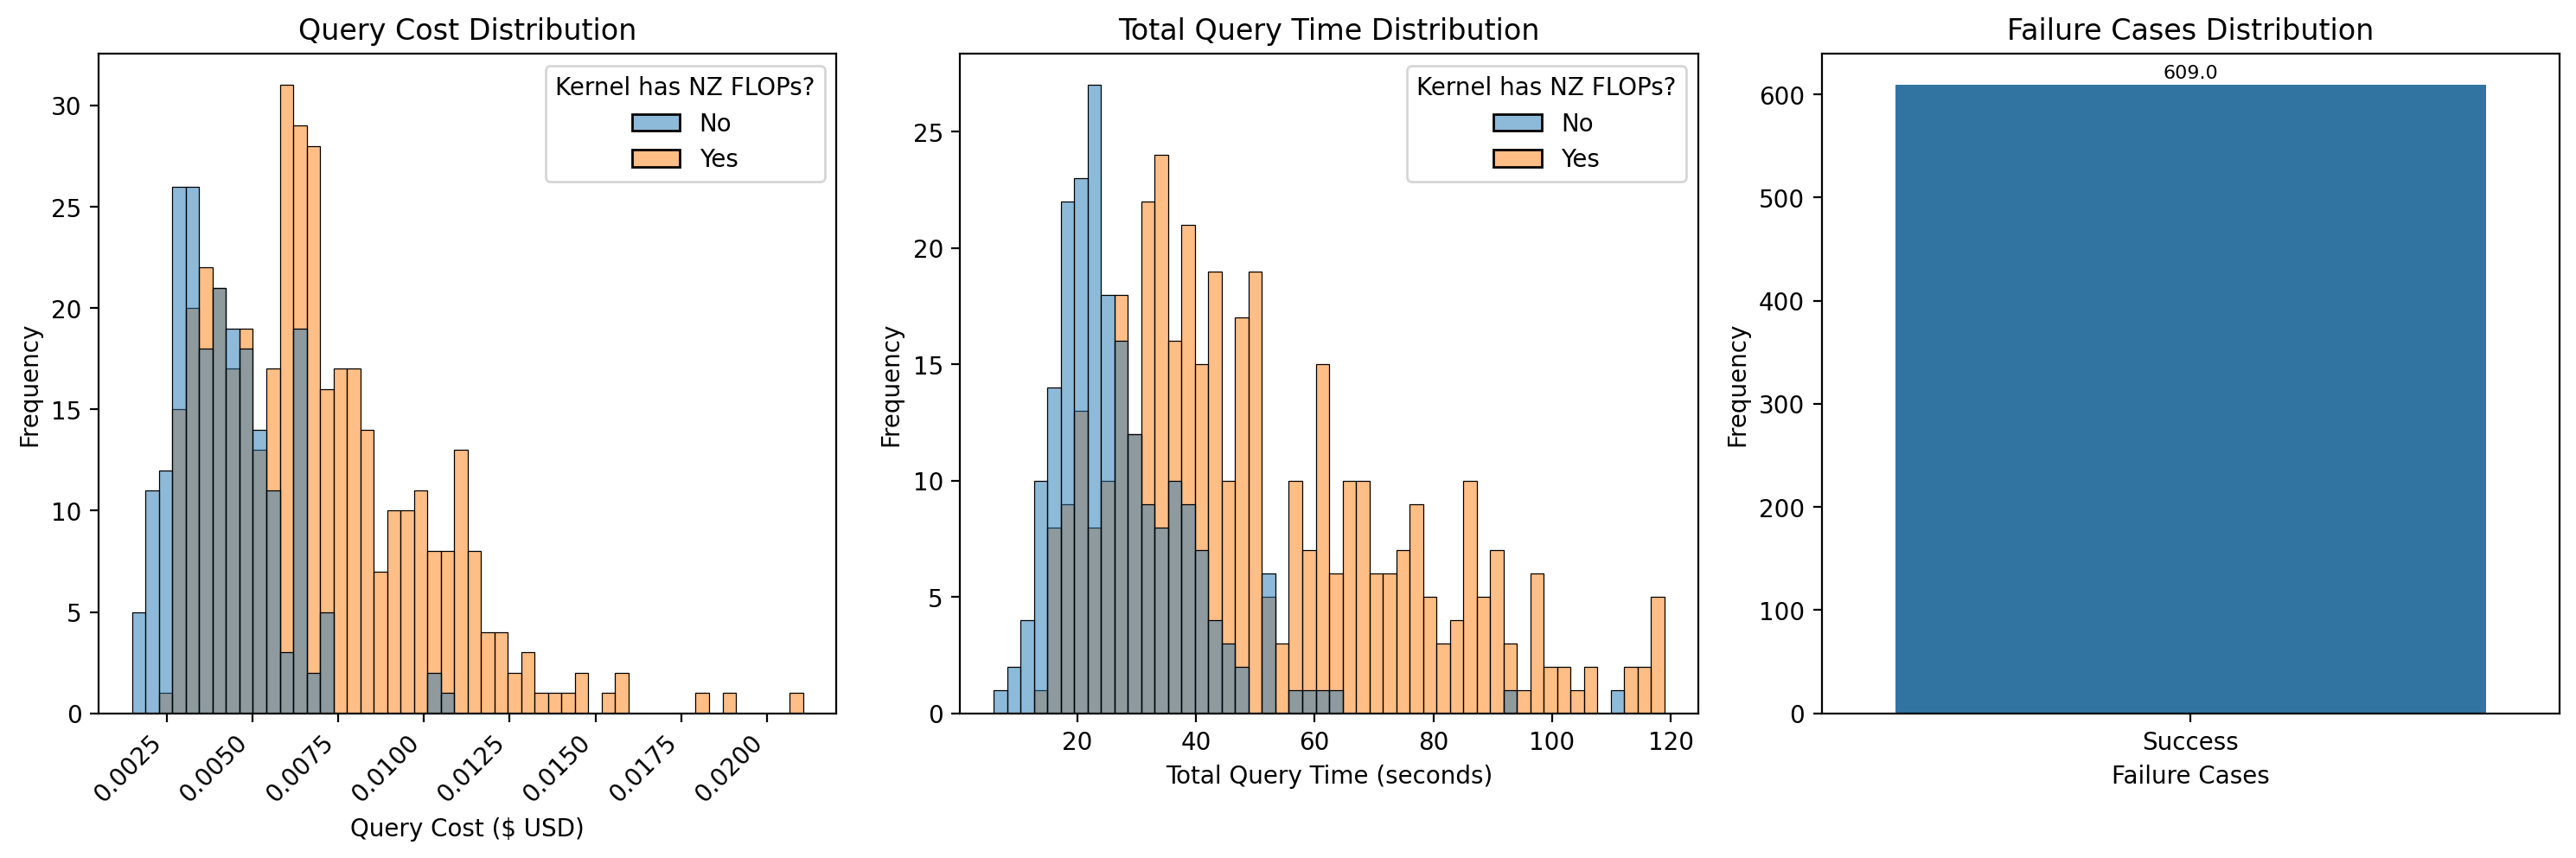

In [78]:
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='full', show_erroneous=False)
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='full', show_erroneous=True)
#plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple')